In [1]:
from get_file_matches import get_tif_file_matches, get_als_tif_matches
from preprocess_and_stack import stack_and_save
from load_train_eval import load_data, train_and_evaluate, visualize_prediction, evaluate_predictions

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score
import rasterio
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import os

In [2]:
def build_improved_fusionnet_unet(input_shape):
    inputs = layers.Input(input_shape)

    def residual_block(x, filters):
        """A simple residual block with shape matching."""
        shortcut = x
        # Adjust the shortcut if the number of filters does not match
        if x.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, (1, 1), padding="same")(shortcut)

        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.Add()([shortcut, x])
        return x

    # Encoder
    c1 = residual_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = residual_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = residual_block(p2, 256)
    c3 = residual_block(c3, 256)

    # Decoder
    u1 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)
    u1 = layers.concatenate([u1, c2])
    c4 = residual_block(u1, 128)

    u2 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)
    u2 = layers.concatenate([u2, c1])
    c5 = residual_block(u2, 64)

    # Final Output
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    return models.Model(inputs, outputs)


In [3]:
als_folder = "data/Tschernitz/als"
dop_folder = "data/Tschernitz/dop"
output_base_dir = "data/Tschernitz/output"

In [4]:
root_dir = "data/Tschernitz"
folder1 = "output"
folder2 = "ground_truth_masks/forest_masks"

# Match stacked TIF and ground truth mask
matches = get_tif_file_matches(root_dir, folder1, folder2, contains1="final_input", contains2="merged")

# Load Data and Train
X, Y = load_data(matches)

# Normalize inputs and binarize ground truth masks
X = X / 255.0
Y = (Y > 0).astype(np.float32)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

Folder1 Path: data/Tschernitz\output
Folder2 Path: data/Tschernitz\ground_truth_masks/forest_masks


Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5317 - loss: 0.7755 - val_accuracy: 0.7363 - val_loss: 0.6661
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6416 - loss: 0.6860 - val_accuracy: 0.6244 - val_loss: 0.6500
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.5930 - loss: 0.6775 - val_accuracy: 0.7604 - val_loss: 0.6338
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7316 - loss: 0.6428 - val_accuracy: 0.7777 - val_loss: 0.5699
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7617 - loss: 0.5656 - val_accuracy: 0.7873 - val_loss: 0.4477
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8136 - loss: 0.4290 - val_accuracy: 0.7774 - val_loss: 0.4631
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7330 - loss: 0.5378 - val_accuracy: 0.8112 - val_loss: 0.3874
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7901 - loss: 0.4363 - val_accuracy: 0.8172 - val_loss: 0.3643
Epoch 9/25
4/4 ━

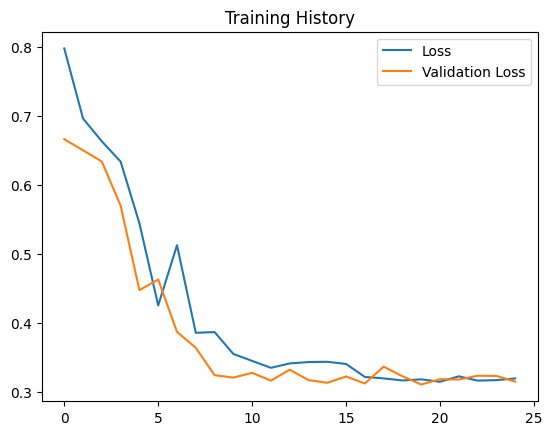

Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step


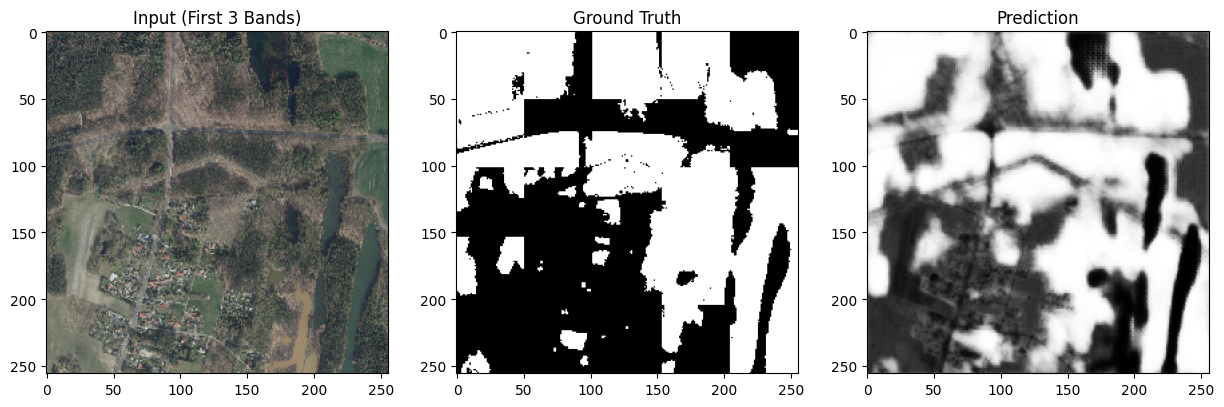

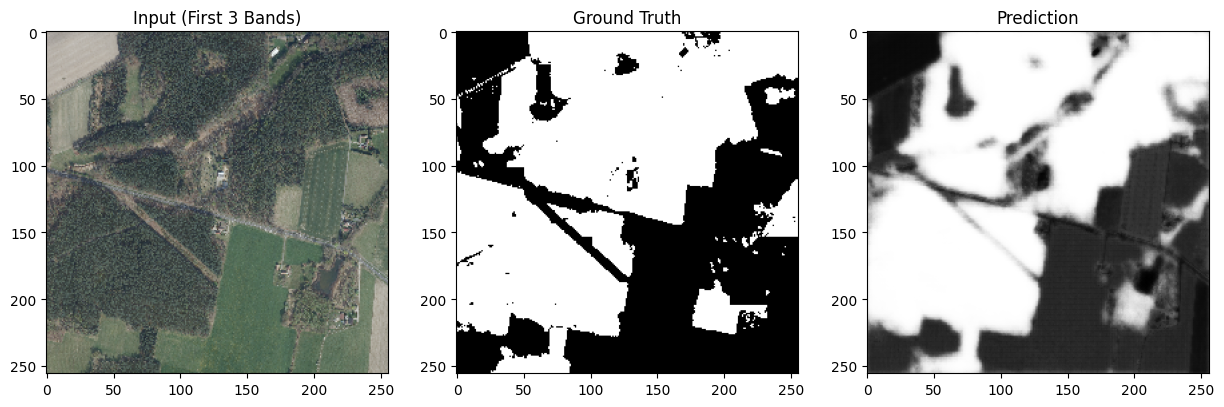

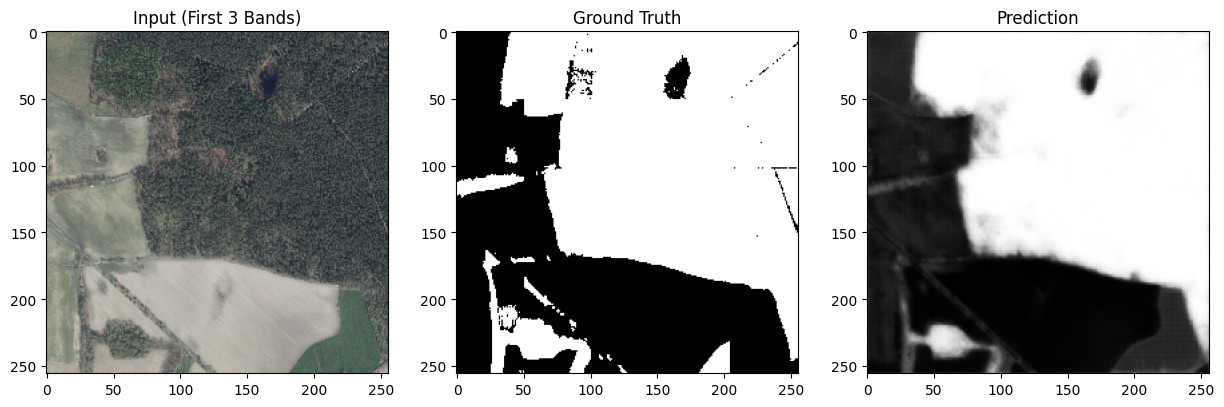

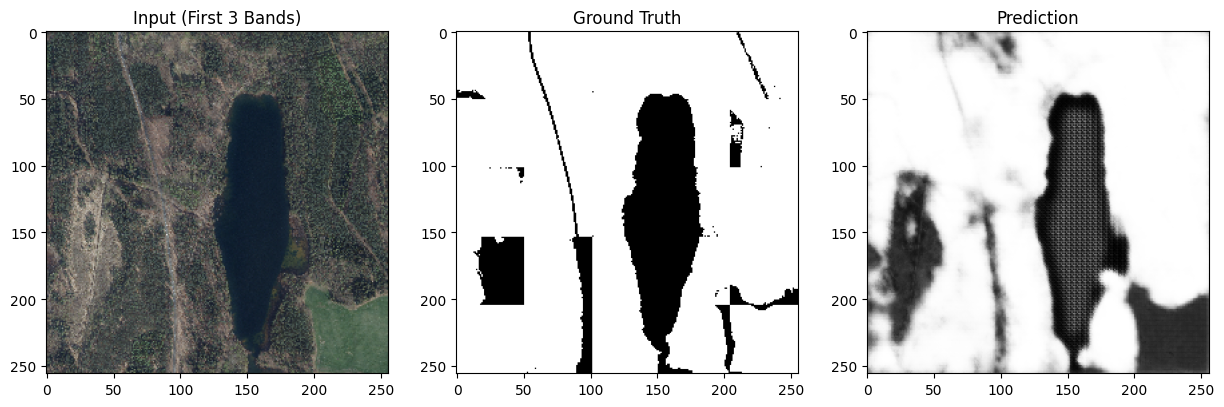

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step

==== Model Evaluation Metrics ====
IoU: 0.8111
Dice: 0.8925
Accuracy: 0.8728
Precision: 0.8985
Recall: 0.8889


In [5]:
fusionnet_results_full = train_and_evaluate(X_train, Y_train, X_val, Y_val, build_improved_fusionnet_unet, batch_size=4, epochs=25, learning_rate=1e-3)

In [6]:
from augmentation_pipeline import augment_dataset, plot_original_and_augmented_versions

augment_configs = [
    {"RandomRotate90": 0.5, "HorizontalFlip": 0.5},
    {"ShiftScaleRotate": {"shift_limit": 0.01, "scale_limit": 0.05, "rotate_limit": 15, "p": 0.5}},
    {"RandomBrightnessContrast": {"brightness_limit": 0.1, "contrast_limit": 0.1, "p": 0.5}},
    {"GaussNoise": {"var_limit": (5.0, 25.0), "p": 0.3}},
]
"""results = {}
for i, config in enumerate(augment_configs):
    print(f"\nApplying Augmentation Configuration {i+1}/{len(augment_configs)}: {config}")
    X_train_aug, Y_train_aug = augment_dataset(X_train, Y_train, config, num_versions=2)
    results[f"Config_{i+1}"] = train_and_evaluate(X_train_aug, Y_train_aug, X_val, Y_val, build_improved_fusionnet_unet, batch_size=4, epochs=25, learning_rate=1e-3, visualize=False)
"""
# Plot the first 3 images and their augmented versions
#plot_original_and_augmented_versions(X_train[:3], X_train_aug, num_samples=3)

'results = {}\nfor i, config in enumerate(augment_configs):\n    print(f"\nApplying Augmentation Configuration {i+1}/{len(augment_configs)}: {config}")\n    X_train_aug, Y_train_aug = augment_dataset(X_train, Y_train, config, num_versions=2)\n    results[f"Config_{i+1}"] = train_and_evaluate(X_train_aug, Y_train_aug, X_val, Y_val, build_improved_fusionnet_unet, batch_size=4, epochs=25, learning_rate=1e-3, visualize=False)\n'